# CIFAR-10 classification with a neural network
# Author: Panov Aleksandr 381903-3m

In [1]:
import tensorflow as tf
import numba as nb
from numba import njit, prange
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import pickle
from PIL import Image

## 1. Load CIFAR-10 dataset and prepare data

In [31]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = unpickle('data/data_batch_1')
test_data = unpickle('data/test_batch')
print(data.keys())
start, end = 2, 23
img_ars = data[b'data'][start:end]
img_labels = data[b'labels'][start:end]
print(len(data[b'labels']))
print(len(img_ars[0]))
print(len(img_ars))
print(type(img_ars[0]))
img_ars = img_ars
for img_ar,i in zip(img_ars, range(start,end)):
    img = Image.fromarray(np.transpose(np.reshape(img_ar,(3, 32,32)), (1,2,0)), 'RGB')
    #img.save(str(i)+'.png')
#print(img_labels)

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
10000
3072
21
<class 'numpy.ndarray'>


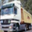

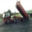

## 2. NN implementation, layers, activations, loss functions and optimizer

In [3]:
@njit(cache=True, parallel=True)
def mult_b(bs, x, y, res):
    n = len(x[0])
    m = len(y[0])
    for b in range(bs):
        for i in prange(n):
            for j in range(m):
                res[i,j] += x[b,i]*y[b,j]

@njit(cache=True, parallel=True)
def mult(x, y, res):
    n = len(x)
    m = len(y)
    for i in prange(n):
        for j in range(m):
            res[i,j] = x[i]*y[j]

class Sigmoid:
    def calc(self, X):
        self.sigmoid = 1.0/(1.0+np.exp(-X))
        return self.sigmoid
    def grad(self, vec_top_grad):
        return vec_top_grad*self.sigmoid*(1.0-self.sigmoid)

class LeakyReLU:
    def __init__(self):
        self.alpha = 0.1
    def calc(self, X):
        self.LeakyReLU = np.where(X>0,X, self.alpha*X)
        return self.LeakyReLU
    def grad(self, vec_top_grad):
        return vec_top_grad*np.where(self.LeakyReLU>0, 1.0, self.alpha)

class SoftMax:
    def __init__(self, n, batch):
        self.n = n
        self.batch = batch
        self.softmax = np.empty((batch, n), dtype='float32')
        self.drop_grad = np.empty((batch, n), dtype='float32')
        self.tmp = np.empty((n,n), dtype='float32')
    def calc(self, X):
        #print('x in softmax', max(X))
        batch = len(X)
        self.softmax = np.exp(X)
        for i in range(batch):
            self.softmax[i] /= np.sum(self.softmax[i])
        return self.softmax
    def grad(self, vec_top_grad):
        for i in range(self.batch):
            mult(-self.softmax[i], self.softmax[i], self.tmp)
            self.tmp[np.diag_indices_from(self.tmp)] += self.softmax[i]#*(1.0-self.softmax)
            self.drop_grad[i] = np.dot(vec_top_grad[i], self.tmp)
        return self.drop_grad
    
def initW(n_input, n_output): # Xavier init
    tmp1 = np.random.normal(0.0, 2.0/(n_input+n_output), size=n_input*n_output)
    tmp1 = tmp1.reshape(n_input,n_output).astype('float32')
    tmp2 = np.random.normal(0.0, 2.0/(n_output+n_output), size=n_output).astype('float32')
    return tmp1, tmp2

In [4]:
class FullConnected:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.n_input = len(W)
        self.n_output = len(b)
        self.new_grad = np.zeros((self.n_input,self.n_output), dtype='float32')
        self.res = np.zeros(self.n_output, dtype='float32')
    def calc(self, x):
        self.x = x
        #vec(x)*matr(W)=vec(y)
        self.res = np.dot(x, self.W)# матрица из batch строк и output cтолбцов
        self.res += self.b
        #print('max W, b, res',np.max(self.W), np.max(self.b), np.max(self.res))
        return self.res
    def grad(self, vec_top_grad):
        batch = len(vec_top_grad)
        # поиск производной выхода y по входу x: d(y)/d(x)
        next_grad = np.matmul(self.W, vec_top_grad.T).T #порядок умножения?
        
        # поиск производной по W
        self.new_grad.fill(0.0)
        mult_b(batch, self.x, vec_top_grad, self.new_grad)
        self.W -= Net.coeff*self.new_grad #Net.coef коэффициент градиентного спуска
        
        # поиск производной по b
        self.b -= Net.coeff*vec_top_grad.sum(axis=0)
        return next_grad

In [73]:
class CrossEntropy:
    def __init__(self, num_classes, batch, eps = 1e-6):
        self.num_classes = num_classes
        self.drop_grad = np.zeros((batch, num_classes), dtype='float32')
        self.eps = eps
    def calc(self, X, labels):
        self.X = X
        cross = 0.0
        for i in range(len(labels)):
            self.X[i,labels[i]] = X[i,labels[i]].clip(min=self.eps, max=1.0)
            cross -= np.log(self.X[i,labels[i]])
        return cross / len(labels)
    def grad(self, labels):
        self.drop_grad.fill(0.0)
        for i in range(len(labels)):
            self.drop_grad[i, labels[i]] = -1.0/self.X[i, labels[i]]
        return self.drop_grad

class Net:
    const_coeff = 0.1
    const_alpha = 0.9
    coeff = None
    def __init__(self, layers, num_classes, batch):
        self.layers = layers
        self.n_layers = len(layers)
        self.cross = CrossEntropy(num_classes, batch)
        self.batch = batch
    def calc(self, x):
        res = None
        for layer in self.layers:
            res = layer.calc(x)
            x = res
        return res
    def get_class(self, x):
        res = self.calc([x])
        return np.argmax(res)#, res
    def get_classes(self, X):
        return [self.get_class(x) for x in X]
    def fit(self, X, Y, n, need_shuffle = False):
        Y = np.array(Y, dtype='int32')
        Net.coeff = Net.const_coeff#/self.batch
        remainder = len(Y) % self.batch
        if remainder > 0:
            X = np.vstack((X, X[0:self.batch-remainder]))
            Y = np.append(Y, Y[0:self.batch-remainder])
        loss = np.zeros(shape=(n, len(Y)//self.batch), dtype='float32')
        for it in range(n):
            if n < 100 and it % 10 == 0: print('EPOCH',it)
            elif it % 100 == 0: print('EPOCH',it)
            np.random.seed(it)
            if need_shuffle: indx = np.random.permutation(len(Y))
            else: indx = range(len(Y))
            for i in range(0, len(Y), self.batch):
                x = X[indx[i:i+self.batch]]
                y = Y[indx[i:i+self.batch]]
                res = self.calc(x)
                # cross res
                loss[it, i//self.batch] = self.cross.calc(res, y)
                gr = self.cross.grad(y)
                for layer in reversed(self.layers):
                    gr = layer.grad(gr)
            Net.coeff *= Net.const_alpha
        return loss.flatten()

## 3. Check correctness

EPOCH 0
EPOCH 10
EPOCH 20
EPOCH 30
0.13545305
9 9
4 4
1 1
1 1
2 2
7 7
8 8
3 3
4 4
7 7
7 7
2 2
9 9
9 9
9 9
3 3
2 2
6 6
4 4
3 3
6 6


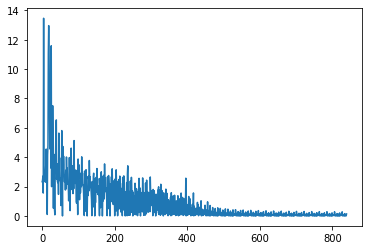

In [6]:
np.random.seed(0)
num_classes = 10
n_input = len(img_ars[0])
batch = 1
epoch = 40
Net.const_coeff = 0.1
Net.const_alpha = 0.9

x = (img_ars/255.0).astype('float32')
labels = img_labels

l1 = FullConnected(*initW(n_input, 192))
leakyReLU = LeakyReLU()
l2 = FullConnected(*initW(192, num_classes))
softmax = SoftMax(num_classes, batch)

net = Net([l1, leakyReLU, l2, softmax],num_classes,batch)
loss = net.fit(x, labels, epoch)
print(loss[-1])
plt.plot(loss)
for i in range(len(x)):
    calc_class = net.get_class(x[i])
    print(labels[i], calc_class)

EPOCH 0
EPOCH 100
0.013405837
9 9
4 4
1 1
1 1
2 2
7 7
8 8
3 3
4 4
7 7
7 7
2 2
9 9
9 9
9 9
3 3
2 2
6 6
4 4
3 3
6 6


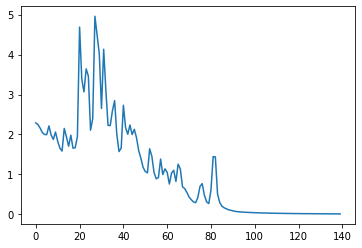

In [7]:
np.random.seed(0)
num_classes = 10
n_input = len(img_ars[0])
batch = 21
epoch = 140
Net.const_coeff = 0.01
Net.const_alpha = 0.999

x = (img_ars/255.0).astype('float32')
labels = img_labels

l1 = FullConnected(*initW(n_input, 192))
leakyReLU = LeakyReLU()
l2 = FullConnected(*initW(192, num_classes))
softmax = SoftMax(num_classes, batch)

net = Net([l1, leakyReLU, l2, softmax],num_classes,batch)
loss = net.fit(x, labels, epoch)
print(loss[-1])
plt.plot(loss)
for i in range(len(x)):
    calc_class = net.get_class(x[i])
    print(labels[i], calc_class)

## 4. Experiments

EPOCH 0
EPOCH 100
EPOCH 200
EPOCH 300
0.116921276


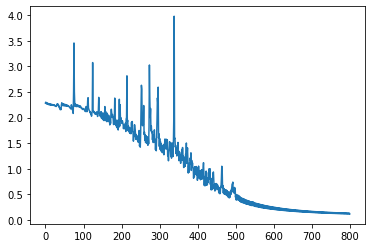

In [21]:
start, end = 0, 128
X = ((data[b'data'][start:end])/255.0).astype('float32')
Labels = data[b'labels'][start:end]

np.random.seed(0)
num_classes = 10
n_input = len(img_ars[0])
batch = 64
epoch = 400
Net.const_coeff = 0.01
Net.const_alpha = 0.99

l1 = FullConnected(*initW(n_input, 768))
leakyReLU1 = LeakyReLU()
l2 = FullConnected(*initW(768, 96))
leakyReLU2 = LeakyReLU()#Sigmoid()
l3 = FullConnected(*initW(96, num_classes))
softmax = SoftMax(num_classes, batch)

net = Net([l1, leakyReLU1, l2, leakyReLU2, l3, softmax],num_classes,batch)
loss = net.fit(X, Labels, epoch)
print(loss[-1])
plt.plot(loss)

EPOCH 0
EPOCH 100
EPOCH 200
EPOCH 300
0.028224241


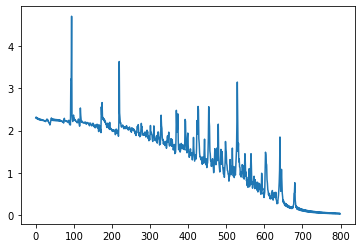

In [22]:
start, end = 0, 128
X = ((data[b'data'][start:end])/255.0).astype('float32')
Labels = data[b'labels'][start:end]

np.random.seed(0)
num_classes = 10
n_input = len(img_ars[0])
batch = 64
epoch = 400
Net.const_coeff = 0.01
Net.const_alpha = 0.995

l1 = FullConnected(*initW(n_input, 512))
leakyReLU1 = LeakyReLU()
l2 = FullConnected(*initW(512, 85))
leakyReLU2 = LeakyReLU()#Sigmoid()
l3 = FullConnected(*initW(85, num_classes))
softmax = SoftMax(num_classes, batch)

net = Net([l1, leakyReLU1, l2, leakyReLU2, l3, softmax],num_classes,batch)
loss = net.fit(X, Labels, epoch)
print(loss[-1])
plt.plot(loss)

EPOCH 0
EPOCH 100
EPOCH 200
EPOCH 300
0.025706219
0.0


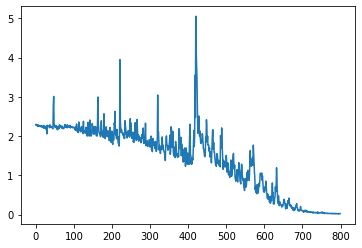

In [17]:
start, end = 0, 128
X = ((data[b'data'][start:end])/255.0).astype('float32')
Labels = data[b'labels'][start:end]

np.random.seed(0)
num_classes = 10
n_input = len(img_ars[0])
batch = 64
epoch = 400
Net.const_coeff = 0.012
Net.const_alpha = 0.995 #0.99 - 0.08

l1 = FullConnected(*initW(n_input, 768))
leakyReLU1 = LeakyReLU()
l2 = FullConnected(*initW(768, 96))
leakyReLU2 = LeakyReLU()#Sigmoid()
l3 = FullConnected(*initW(96, num_classes))
softmax = SoftMax(num_classes, batch)

net = Net([l1, leakyReLU1, l2, leakyReLU2, l3, softmax],num_classes,batch)
loss = net.fit(X, Labels, epoch, True)
print(loss[-1])
plt.plot(loss)
print(np.mean(Labels != net.get_classes(X)))

EPOCH 0
1.7962493


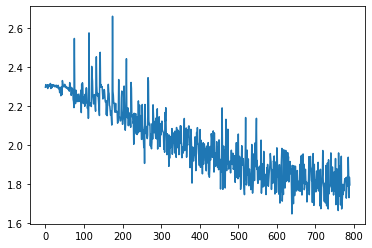

In [83]:
tart, end = 0, 10000
X = ((data[b'data'][start:end])/255.0).astype('float32')
Labels = data[b'labels'][start:end]
X_test = ((test_data[b'data'][start:end])/255.0).astype('float32')
Y_test = test_data[b'labels'][start:end]

np.random.seed(0)
num_classes = 10
n_input = len(img_ars[0])
batch = 128

l1 = FullConnected(*initW(n_input, 512))
leakyReLU1 = LeakyReLU()
l2 = FullConnected(*initW(512, 128)) #128 0.03487363 #85 0.050611287
leakyReLU2 = LeakyReLU()#Sigmoid()
l3 = FullConnected(*initW(128, num_classes))
softmax = SoftMax(num_classes, batch)

epoch = 10
Net.const_coeff = 0.005
Net.const_alpha = 0.8
net = Net([l1, leakyReLU1, l2, leakyReLU2, l3, softmax], num_classes,batch)
loss = net.fit(X, Labels, epoch, True)
print(loss[-1])
plt.plot(loss)

EPOCH 0
1.6950108


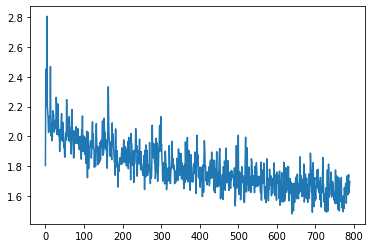

In [87]:
epoch = 10
Net.const_coeff = 0.003
Net.const_alpha = 0.9
net = Net([l1, leakyReLU1, l2, leakyReLU2, l3, softmax],num_classes, batch)
loss = net.fit(X, Labels, epoch, True)
print(loss[-1])
plt.plot(loss)

In [88]:
res = net.get_classes(X_test)
Y_test = np.array(Y_test, dtype='int64')
print(np.mean(Y_test == res))

0.39907981596319264
